In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install "munch==2.5.0"

# Get data

In [3]:
%cd /content
!git clone https://github.com/ejkim47/bridging-gap-wsol.git bridging
%cd bridging

/content
Cloning into 'bridging'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 33 (delta 5), reused 29 (delta 3), pack-reused 0
Receiving objects: 100% (33/33), 178.20 KiB | 5.57 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/bridging


In [4]:
%cd /content
!git clone -n --depth=1 --filter=tree:0 \
  https://github.com/clovaai/wsolevaluation.git
%cd wsolevaluation
!git sparse-checkout set --no-cone metadata
!git checkout
!cp -r /content/wsolevaluation/metadata /content/bridging

/content
Cloning into 'wsolevaluation'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (1/1), done.
/content/wsolevaluation
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 0), reused 21 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 3.62 KiB | 370.00 KiB/s, done.
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 32 (delta 11), reused 32 (delta 11), pack-reused 0
Receiving objects: 100% (32/32), 11.17 MiB | 5.59 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (37/37), done.
Your branch is up to date with 'origin/master'.


In [ ]:
%%bash
cd /content/bridging
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45" -nc -O dataset/CUB_200_2011.tgz && rm -rf /tmp/cookies.txt
gdown -O dataset/CUBV2.tar 1U6cwKHS65wayT9FFvoLIA8cn1k0Ot2M1
mkdir -p dataset/CUB_200_2011
tar xvf dataset/CUB_200_2011.tgz -C dataset/
mv dataset/CUB_200_2011/images dataset/CUB && rm -rf dataset/CUB_200_2011
tar xvf dataset/CUBV2.tar -C dataset/CUB

# Testing model with better concat pipeline

In [6]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import io
import base64

from google.colab.patches import cv2_imshow
from PIL import Image
from PIL.ImageShow import IPythonViewer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [7]:
# Directory where images are located
image_directory = '/content/bridging/dataset/CUB'

# Directory for txt metadata
metadata_directory = '/content/bridging/metadata/CUB/val'

class_labels_path = f'{metadata_directory}/class_labels.txt'
image_ids_path = f'{metadata_directory}/image_ids.txt'
image_sizes_path = f'{metadata_directory}/image_sizes.txt'
localization_path = f'{metadata_directory}/localization.txt'

with open(class_labels_path, 'r') as f:
    class_labels = np.array(list(map(str.strip, f.readlines())))

with open(image_ids_path, 'r') as f:
    image_ids = np.array(list(map(str.strip, f.readlines())))

with open(image_sizes_path, 'r') as f:
    image_sizes = np.array(list(map(str.strip, f.readlines())))

with open(localization_path, 'r') as f:
    localization = np.array(list(map(str.strip, f.readlines())))

# # Testing for index order
# for id_str, label_str, size_str, bbox_str in zip(image_ids, class_labels, image_sizes, localization):
#     assert len(set([id_str, label_str.split(',')[0], size_str.split(',')[0], bbox_str.split(',')[0]])) == 1

# Shuffle annottation
rng = np.random.default_rng(42)

annotation = np.array([f'{id_str}|{label_str}|{size_str}|{bbox_str}'
    for id_str, label_str, size_str, bbox_str in zip(image_ids, class_labels, image_sizes, localization)])

rng.shuffle(annotation)

image_ids = np.array([ann.split('|')[0] for ann in annotation]).reshape(-1, 4)
class_labels = np.array([ann.split('|')[1] for ann in annotation]).reshape(-1, 4)
image_sizes = np.array([ann.split('|')[2] for ann in annotation]).reshape(-1, 4)
localization = np.array([ann.split('|')[3] for ann in annotation]).reshape(-1, 4)

# # Testing
# for id_grp, label_grp, size_grp, bbox_grp in zip(image_ids, class_labels, image_sizes, localization):
#     temp = list(map(lambda x: x.split(',')[0], id_grp))
#     temp.extend(list(map(lambda x: x.split(',')[0], label_grp)))
#     temp.extend(list(map(lambda x: x.split(',')[0], size_grp)))
#     temp.extend(list(map(lambda x: x.split(',')[0], bbox_grp)))
#     assert len(set(temp)) == 4

raw_concat_images = []
raw_images = []
labels = []

for id, (id_grp, label_grp, size_grp, bbox_grp) in enumerate(zip(image_ids, class_labels, image_sizes, localization)):
    # if id == 4:
    #     break

    # for i in id_grp:
    #     print(i)
    #     IPythonViewer().show(Image.open(f'{image_directory}/{i}').resize((224, 224)))

    # Open the four images
    image1 = Image.open(f'{image_directory}/{id_grp[0]}')
    image2 = Image.open(f'{image_directory}/{id_grp[1]}')
    image3 = Image.open(f'{image_directory}/{id_grp[2]}')
    image4 = Image.open(f'{image_directory}/{id_grp[3]}')

    raw_images.extend([image1, image2, image3, image4])

    # Find the image with the minimum size
    min_width = min(image1.width, image2.width, image3.width, image4.width)
    min_height = min(image1.height, image2.height, image3.height, image4.height)

    # Resize the images to match the size of the smallest image
    image1_resized = image1.resize((min_width, min_height))
    image2_resized = image2.resize((min_width, min_height))
    image3_resized = image3.resize((min_width, min_height))
    image4_resized = image4.resize((min_width, min_height))

    # Calculate the dimensions of the merged image
    merged_width = 2 * min_width
    merged_height = 2 * min_height

    # Create a new blank canvas with the calculated dimensions
    canvas = Image.new('RGB', (merged_width, merged_height))

    # Paste each image into the desired corner of the canvas
    canvas.paste(image1_resized, (0, 0))  # Top-left corner
    canvas.paste(image2_resized, (min_width, 0))  # Top-right corner
    canvas.paste(image3_resized, (0, min_height))  # Bottom-left corner
    canvas.paste(image4_resized, (min_width, min_height))  # Bottom-right corner

    # IPythonViewer().show(canvas)

    label = [int(l.split(',')[-1]) for l in label_grp]

    for i in label:
        raw_concat_images.append(canvas)
        labels.append(i)


In [8]:
print(len(raw_concat_images))
print(len(raw_images))
print(len(labels))

1000
1000
1000


### Create dataset

In [9]:
_IMAGE_MEAN_VALUE = [0.485, 0.456, 0.406]
_IMAGE_STD_VALUE = [0.229, 0.224, 0.225]


class CUBDataset(Dataset):
    def __init__(self, raw_concat_images, raw_images, targets):
        self.raw_concat_images = raw_concat_images
        self.raw_images = raw_images
        self.targets = targets
        self.transform = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize(_IMAGE_MEAN_VALUE, _IMAGE_STD_VALUE)
                        ])

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        concat_image = self.raw_concat_images[idx]
        image = self.raw_images[idx]
        target = self.targets[idx]

        return self.transform(concat_image), self.transform(image), torch.tensor(target)


In [10]:
dataloader = DataLoader(
    CUBDataset(raw_concat_images, raw_images, labels),
    batch_size=12,
    num_workers=1
)

### Get trained model

In [11]:
%cd /content/bridging
import argparse
import yaml
import os

from util import set_random_seed
from trainer import Trainer
from config import *

def get_configs():
    # Set the flag values directly
    flags = argparse.Namespace()
    flags.config = '/content/drive/MyDrive/CUB-200-2011-Result/attempt_to_training_full_epoch/CUB_resnet50_bridging-gap/config_exp.yaml'
    flags.gpu = '0'
    flags.save_cam = False
    flags.only_eval = True

    with open(flags.config, 'rb') as f:
        conf = yaml.load(f.read(), Loader=yaml.FullLoader)
    conf.update(vars(flags))
    args = argparse.Namespace(**conf)

    check_dependency(args)
    args.log_folder = configure_log_folder(args)
    configure_log(args)
    configure_config(args)
    box_v2_metric(args)

    args.architecture_type = get_architecture_type(args.wsol_method)
    args.data_paths = configure_data_paths(args)
    args.metadata_root = ospj(args.metadata_root, args.dataset_name)
    args.scoremap_paths = configure_scoremap_output_paths(args)
    args.lr_decay_points = configure_lr_decay(args)
    return args

# Call the function to get the configurations
args = get_configs()
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

set_random_seed(args.seed)
trainer = Trainer(args)

trainer.load_checkpoint(checkpoint_type='best')
# trainer.evaluate(epoch='best', split='val')
# trainer.print_performances()

/content/bridging
/content/drive/MyDrive/CUB-200-2011-Result/attempt_to_training_full_epoch/CUB_resnet50_bridging-gap/
Inference with last_checkpoint and best_checkpoint in /content/drive/MyDrive/CUB-200-2011-Result/attempt_to_training_full_epoch/CUB_resnet50_bridging-gap/
Loading model resnet50


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Check /content/drive/MyDrive/CUB-200-2011-Result/attempt_to_training_full_epoch/CUB_resnet50_bridging-gap/best_checkpoint.pth.tar loaded.


In [12]:
def normalize_scoremap(cam):
    """
    Args:
        cam: numpy.ndarray(size=(H, W), dtype=np.float)
    Returns:
        numpy.ndarray(size=(H, W), dtype=np.float) between 0 and 1.
        If input array is constant, a zero-array is returned.
    """
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam

In [ ]:
trainer.model_multi.eval()

tensor(35, device='cuda:0')


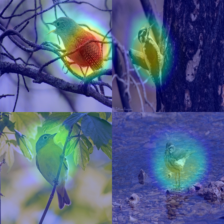

tensor(174, device='cuda:0')


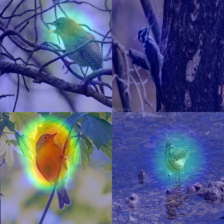

tensor(37, device='cuda:0')


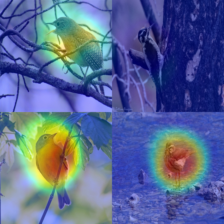

tensor(87, device='cuda:0')


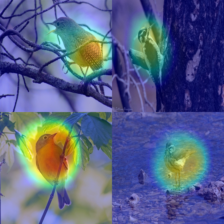

tensor(15, device='cuda:0')


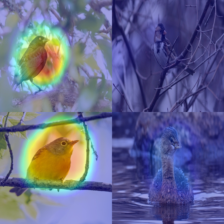

tensor(171, device='cuda:0')


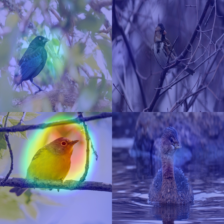

tensor(96, device='cuda:0')


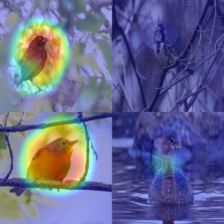

tensor(33, device='cuda:0')


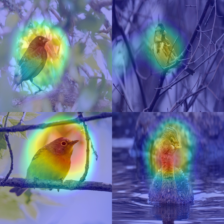

tensor(168, device='cuda:0')


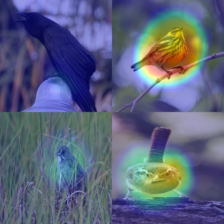

tensor(162, device='cuda:0')


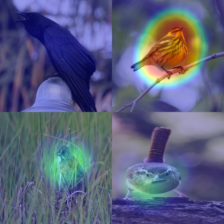

tensor(12, device='cuda:0')


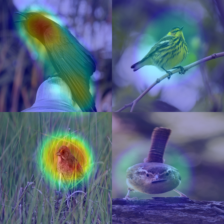

tensor(170, device='cuda:0')


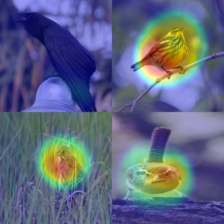

In [35]:
_IMAGENET_MEAN = [0.485, .456, .406]
_IMAGENET_STDDEV = [.229, .224, .225]


for batch_idx, sample in enumerate(dataloader):
    concat_images = sample[0]
    images = sample[1]
    targets = sample[2]

    image_size = images.numpy().shape[2:]

    # Forward on concat images
    concat_images = concat_images.cuda()
    concat_outputs = trainer.model_multi(concat_images, labels=targets, return_cam=True)

    # Get topk predicted label
    _, concat_pred_topk = torch.sort(concat_outputs['logits'], dim=1, descending=True)

    # Make predicted labels as target and feed to the network to get cam
    pred_as_targets = torch.flatten(concat_pred_topk[::4, :4])
    concat_outputs = trainer.model_multi(concat_images, labels=pred_as_targets, return_cam=True)

    concat_cams = concat_outputs['cams'].detach().cpu().numpy().astype(float)
    concat_images = concat_images.detach().cpu()

    for concat_image, concat_cam, concat_y_hat in zip(concat_images, concat_cams, pred_as_targets):
        print(concat_y_hat)
        concat_cam_resized = cv2.resize(concat_cam, image_size, interpolation=cv2.INTER_CUBIC)

        concat_cam_normalized = normalize_scoremap(concat_cam_resized)

        concat_heatmap = cv2.applyColorMap(np.uint8(255*concat_cam_normalized), cv2.COLORMAP_JET)

        concat_image_orig = concat_image * torch.tensor(_IMAGENET_STDDEV).view(3, 1, 1) + torch.tensor(_IMAGENET_MEAN).view(3, 1, 1)

        # Heatmap for concat image
        concat_heatmap = np.float32(concat_heatmap) / 255
        concat_heatmap = concat_heatmap[...,::-1]
        concat_overlayed = 0.5 * concat_image_orig.permute(1, 2, 0).numpy() + 0.3 * concat_heatmap

        concat_overlayed = cv2.normalize(concat_overlayed, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        concat_overlayed = concat_overlayed.astype(np.uint8)
        concat_overlayed = cv2.cvtColor(concat_overlayed, cv2.COLOR_BGR2RGB)
        cv2_imshow(concat_overlayed)

    break

tensor(195)
[ 35 174  37  87]
[8.91 8.7  8.69 8.51]


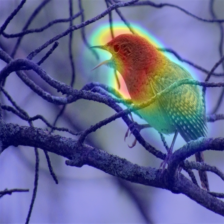

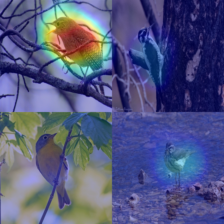

tensor(186)
[ 35 174  37  87]
[8.91 8.7  8.69 8.51]


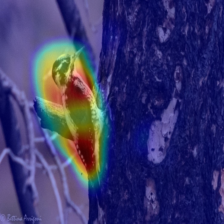

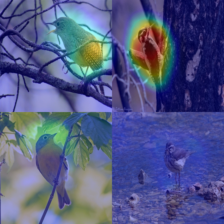

tensor(171)
[ 35 174  37  87]
[8.91 8.7  8.69 8.51]


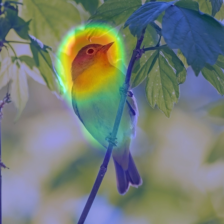

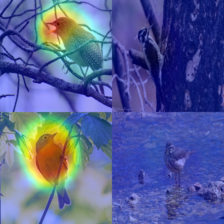

tensor(183)
[ 35 174  37  87]
[8.91 8.7  8.69 8.51]


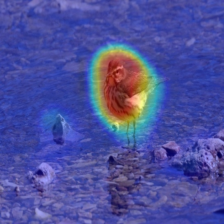

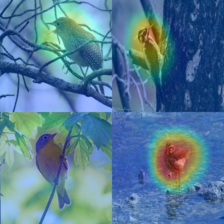

tensor(25)
[ 15 171  96  33]
[12.92 11.59 11.44 11.19]


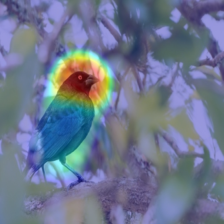

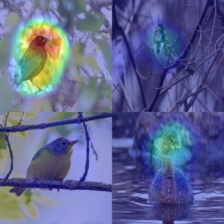

tensor(121)
[ 15 171  96  33]
[12.92 11.59 11.44 11.19]


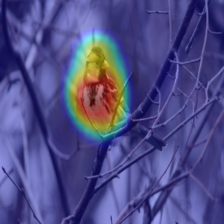

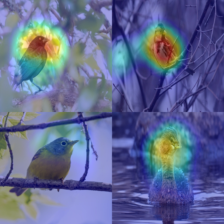

tensor(171)
[ 15 171  96  33]
[12.92 11.59 11.44 11.19]


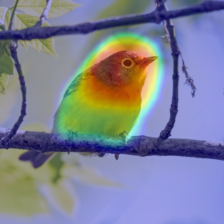

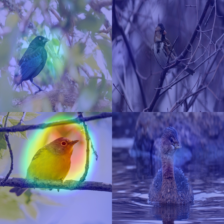

tensor(51)
[ 15 171  96  33]
[12.92 11.59 11.44 11.19]


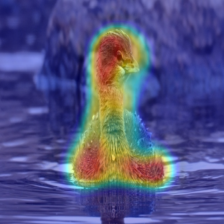

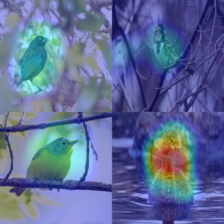

tensor(29)
[168 162  12 170]
[14.38 12.89 11.8  11.72]


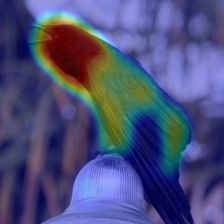

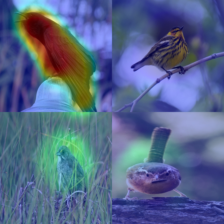

tensor(162)
[168 162  12 170]
[14.38 12.89 11.8  11.72]


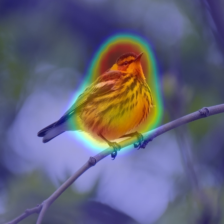

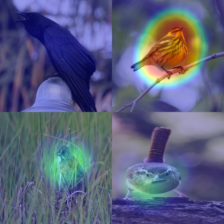

tensor(127)
[168 162  12 170]
[14.38 12.89 11.8  11.72]


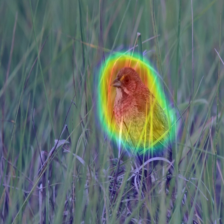

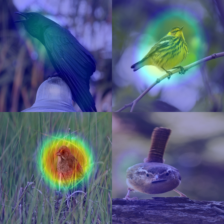

tensor(194)
[168 162  12 170]
[14.38 12.89 11.8  11.72]


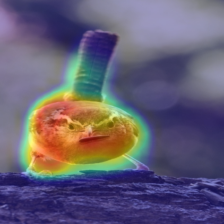

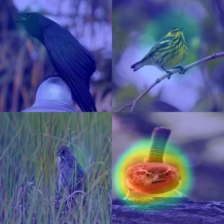

In [36]:
_IMAGENET_MEAN = [0.485, .456, .406]
_IMAGENET_STDDEV = [.229, .224, .225]


for batch_idx, sample in enumerate(dataloader):
    concat_images = sample[0]
    images = sample[1]
    targets = sample[2]

    image_size = images.numpy().shape[2:]

    # Forward on original images
    images = images.cuda()
    outputs = trainer.model_multi(images, labels=targets, return_cam=True)

    # pred_topk = (torch.argsort(outputs['logits'], dim=1, descending=True)[:, :1]).detach().cpu().numpy()
    # print(f'On original images: {pred_topk[:, 0]}')

    cams = outputs['cams'].detach().cpu().numpy().astype(float)
    images = images.detach().cpu()

    # Forward on concat images
    concat_images = concat_images.cuda()
    concat_outputs = trainer.model_multi(concat_images, labels=targets, return_cam=True)

    concat_pred_topk_scores, concat_pred_topk = [i.detach().cpu().numpy()[:, :4] for i in torch.sort(concat_outputs['logits'], dim=1, descending=True)]
    # print(f'On concat images: {concat_pred_topk[:, 0]}')

    concat_cams = concat_outputs['cams'].detach().cpu().numpy().astype(float)
    concat_images = concat_images.detach().cpu()

    batch_row_content = ''
    count = 0

    for image, cam, concat_image, concat_cam, gt, concat_y_hat, concat_y_hat_score in zip(images, cams, concat_images, concat_cams, targets, concat_pred_topk, concat_pred_topk_scores):
        print(gt)
        print(concat_y_hat)
        print(np.array2string(concat_y_hat_score, precision=2))

        cam_resized = cv2.resize(cam, image_size, interpolation=cv2.INTER_CUBIC)
        concat_cam_resized = cv2.resize(concat_cam, image_size, interpolation=cv2.INTER_CUBIC)

        cam_normalized = normalize_scoremap(cam_resized)
        concat_cam_normalized = normalize_scoremap(concat_cam_resized)

        heatmap = cv2.applyColorMap(np.uint8(255*cam_normalized), cv2.COLORMAP_JET)
        concat_heatmap = cv2.applyColorMap(np.uint8(255*concat_cam_normalized), cv2.COLORMAP_JET)

        image_orig = image * torch.tensor(_IMAGENET_STDDEV).view(3, 1, 1) + torch.tensor(_IMAGENET_MEAN).view(3, 1, 1)
        concat_image_orig = concat_image * torch.tensor(_IMAGENET_STDDEV).view(3, 1, 1) + torch.tensor(_IMAGENET_MEAN).view(3, 1, 1)

        # Heatmap for original image
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]
        overlayed = 0.5 * image_orig.permute(1, 2, 0).numpy() + 0.3 * heatmap

        overlayed = cv2.normalize(overlayed, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        overlayed = overlayed.astype(np.uint8)
        overlayed = cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB)
        cv2_imshow(overlayed)

        # Heatmap for concat image
        concat_heatmap = np.float32(concat_heatmap) / 255
        concat_heatmap = concat_heatmap[...,::-1]
        concat_overlayed = 0.5 * concat_image_orig.permute(1, 2, 0).numpy() + 0.3 * concat_heatmap

        concat_overlayed = cv2.normalize(concat_overlayed, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        concat_overlayed = concat_overlayed.astype(np.uint8)
        concat_overlayed = cv2.cvtColor(concat_overlayed, cv2.COLOR_BGR2RGB)
        cv2_imshow(concat_overlayed)
    break

In [ ]:
_IMAGENET_MEAN = [0.485, .456, .406]
_IMAGENET_STDDEV = [.229, .224, .225]

html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Image and Text</title>
</head>
<body>
    <h1>Image and Text</h1>
    <table border="1">
        <tr>
            <th>Label</th>
            <th>Concat Image Image</th>
            <th>Original Image Heatmap</th>
            <th>Predict on Concat Image</th>
        </tr>
"""
with open('/content/result.html', 'a+') as f:
    f.write(html_content)


for batch_idx, sample in enumerate(dataloader):
    concat_images = sample[0]
    images = sample[1]
    targets = sample[2]

    image_size = images.numpy().shape[2:]

    # Forward on original images
    images = images.cuda()
    outputs = trainer.model_multi(images, labels=targets, return_cam=True)

    # pred_topk = (torch.argsort(outputs['logits'], dim=1, descending=True)[:, :1]).detach().cpu().numpy()
    # print(f'On original images: {pred_topk[:, 0]}')

    cams = outputs['cams'].detach().cpu().numpy().astype(float)
    images = images.detach().cpu()

    # Forward on concat images
    concat_images = concat_images.cuda()
    concat_outputs = trainer.model_multi(concat_images, labels=targets, return_cam=True)

    concat_pred_topk_scores, concat_pred_topk = [i.detach().cpu().numpy()[:, :4] for i in torch.sort(concat_outputs['logits'], dim=1, descending=True)]
    # print(f'On concat images: {concat_pred_topk[:, 0]}')

    concat_cams = concat_outputs['cams'].detach().cpu().numpy().astype(float)
    concat_images = concat_images.detach().cpu()

    batch_row_content = ''
    count = 0

    for image, cam, concat_image, concat_cam, gt, concat_y_hat, concat_y_hat_score in zip(images, cams, concat_images, concat_cams, targets, concat_pred_topk, concat_pred_topk_scores):
        # print(gt)
        # print(concat_y_hat)
        # print(np.array2string(concat_y_hat_score, precision=2))

        cam_resized = cv2.resize(cam, image_size, interpolation=cv2.INTER_CUBIC)
        concat_cam_resized = cv2.resize(concat_cam, image_size, interpolation=cv2.INTER_CUBIC)

        cam_normalized = normalize_scoremap(cam_resized)
        concat_cam_normalized = normalize_scoremap(concat_cam_resized)

        heatmap = cv2.applyColorMap(np.uint8(255*cam_normalized), cv2.COLORMAP_JET)
        concat_heatmap = cv2.applyColorMap(np.uint8(255*concat_cam_normalized), cv2.COLORMAP_JET)

        image_orig = image * torch.tensor(_IMAGENET_STDDEV).view(3, 1, 1) + torch.tensor(_IMAGENET_MEAN).view(3, 1, 1)
        concat_image_orig = concat_image * torch.tensor(_IMAGENET_STDDEV).view(3, 1, 1) + torch.tensor(_IMAGENET_MEAN).view(3, 1, 1)

        # Heatmap for original image
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]
        overlayed = 0.5 * image_orig.permute(1, 2, 0).numpy() + 0.3 * heatmap

        overlayed = cv2.normalize(overlayed, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        overlayed = overlayed.astype(np.uint8)
        overlayed = cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB)
        # cv2_imshow(overlayed)

        # Heatmap for concat image
        concat_heatmap = np.float32(concat_heatmap) / 255
        concat_heatmap = concat_heatmap[...,::-1]
        concat_overlayed = 0.5 * concat_image_orig.permute(1, 2, 0).numpy() + 0.3 * concat_heatmap

        concat_overlayed = cv2.normalize(concat_overlayed, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        concat_overlayed = concat_overlayed.astype(np.uint8)
        concat_overlayed = cv2.cvtColor(concat_overlayed, cv2.COLOR_BGR2RGB)
        # cv2_imshow(concat_overlayed)


        original_image_heatmap = Image.fromarray(overlayed[..., ::-1])
        concat_image_heatmap = Image.fromarray(concat_overlayed[..., ::-1])

        original_image_heatmap_buffer = io.BytesIO()
        original_image_heatmap.save(original_image_heatmap_buffer, format="PNG")
        original_image_heatmap_base64 = base64.b64encode(original_image_heatmap_buffer.getvalue()).decode('utf-8')


        concat_image_heatmap_buffer = io.BytesIO()
        concat_image_heatmap.save(concat_image_heatmap_buffer, format="PNG")
        concat_image_heatmap_base64 = base64.b64encode(concat_image_heatmap_buffer.getvalue()).decode('utf-8')


        batch_row_content += f"""
            <tr>
                <td>{gt.numpy()}</td>
                <td><img src="data:image/jpeg;base64,{original_image_heatmap_base64}" alt="Original Image Heatmap" width="300"></td>
                <td><img src="data:image/jpeg;base64,{concat_image_heatmap_base64}" alt="Concat Image Heatmap" width="300"></td>
                <td>Predicted class: {concat_y_hat}<br>Predicted score {np.array2string(concat_y_hat_score, precision=2)}</td>
            </tr>
        """

        if count == 3:
            count = 0
            batch_row_content += f"""
                <tr>
                    <td colspan="4" style="text-align:center; background-color: #f7f707;">Empty Row</td>
                </tr>
            """
        else:
            count += 1

        # image_orig = cv2.normalize(image_orig.permute(1, 2, 0).numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        # superimposed = cv2.addWeighted(heatmap, 0.3, image_orig.astype(np.uint8), 0.5, 0)
        # cv2_imshow(superimposed)

        # print('-------------')
    with open('/content/result.html', 'a+') as f:
        f.write(batch_row_content)

with open('/content/result.html', 'a+') as f:
    f.write("""
    </table>
</body>
</html>
""")